In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


# **Introduction**

The objective of this colab is to demonstrate `MLP Project` on<font color='blue'>
 **Recipe for Rating: Predict Food Ratings using ML**</font>.

_Hi there, my name is `Prem Kumar Gupta` and this colab is created by me to show you my final project for Machine learning Practice Course._

# **Imports**

In [2]:
import numpy as np
import pandas as pd
import regex as re
import seaborn as sns
import string
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import (cross_validate, train_test_split,
                                     ShuffleSplit)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# **Common set up**

Set up random seed to a number of your choice.

---

In [3]:
np.random.seed(306)

# **Loading the dataset**

In [4]:
train = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv')
train_copy = train.copy()

In [5]:
test = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv')
test_copy = test.copy()

## Check data samples

In [6]:
train.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


## Features

**Columns Description**

The dataset comprises various columns, each offering valuable insights into taxi rides. Notably:

`RecipeNumber`: Placement of the recipe on the top 100 recipes list.

`RecipeCode`: Unique ID of the recipe used by the site`.

`RecipeName ` Name of the recipe the comment was posted on.

`CommentID`: Unique ID of the comment.

`UserID`: Unique ID of the user who left the comment.

`UserName`: Name of the user.

`UserReputation`: Internal score of the site, roughly quantifying the past behavior of the user.

`CreationTimestamp` Time at which the comment was posted as a Unix timestamp.

`ReplyCount`: Number of replies to the comment.

`ThumbsUpCount`: Number of up-votes the comment has received.

`ThumbsDownCount`: Number of down-votes the comment has received.

**`Rating`**: The score on a 1 to 5 scale that the user gave to the recipe (Target Variable).

`BestScore`: Score of the comment, likely used by the site to help determine the order comments appear in.

`Recipe_Review`: Text content of the comment.


## Data statistics

In [7]:
train_copy.shape

(13636, 15)

In [8]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


In [9]:
train_copy.describe(include='all')

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
count,13636.000000,13636.000000,13636.000000,13636,13636,13636,13636,13636.000000,1.363600e+04,13636.000000,13636.000000,13636.000000,13636.000000,13636.000000,13634
unique,NaN,NaN,NaN,100,13636,10783,10620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13370
top,NaN,NaN,NaN,Cheeseburger Soup,sp_aUSaElGf_12259_c_149978,u_1oKVZoIOMWJ2j7TA7py2BIbf1mm,mjlouk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Delicious!
freq,NaN,NaN,NaN,553,1,20,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
mean,121.085289,38.624377,21785.990833,NaN,NaN,NaN,NaN,2.160311,1.623713e+09,0.014520,1.098269,0.543708,4.288721,153.127897,NaN
std,116.995633,29.672351,23883.189918,NaN,NaN,NaN,NaN,10.086424,5.444020e+06,0.137323,4.166487,3.265660,1.544839,140.986908,NaN
min,0.000000,1.000000,386.000000,NaN,NaN,NaN,NaN,0.000000,1.613035e+09,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,45.000000,12.000000,6504.000000,NaN,NaN,NaN,NaN,1.000000,1.622717e+09,0.000000,0.000000,0.000000,5.000000,100.000000,NaN
50%,91.000000,33.000000,14600.000000,NaN,NaN,NaN,NaN,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000,NaN
75%,148.000000,63.000000,33121.000000,NaN,NaN,NaN,NaN,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000,NaN


In [10]:
# Find duplicates in 'Recipe_Review' column
duplicates = train_copy[train_copy.duplicated(subset=['Recipe_Review'], keep=False)]

# Print the duplicates along with their indices
print(duplicates.shape)
for index, row in duplicates.iterrows():
    print(f"Index: {index}, Recipe_Review: {row['Recipe_Review']}")

(468, 15)
Index: 60, Recipe_Review: I&#39;ve been making a variation of this for years.  My husband loves it.Tip:  it&#39;s way easier to add the extra butter and then the flour to the celery and onion mixture than it is to make a separate roux.  You have more control over how thick your soup will be and you don&#39;t have to mess up an extra pan.  It&#39;s an extra step that&#39;s very unnecessary.
Index: 69, Recipe_Review: Very good.
Index: 75, Recipe_Review: This is THE best white chili I have ever made.  My guys at work request this all the time during the winter.
Index: 96, Recipe_Review: I have made this several times, my whole family love them, I double everything using 2 lbs of burger, I do not put the sauce on to bake as directed, it all runs off into the grease, they like to put it on afterwards &amp; on their potaotes. A family favorite, Enjoy !
Index: 177, Recipe_Review: I went out on a limb with this one because the guys in my family are all about the red chili and don&#39

In [11]:
duplicates.head(10)

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
60,414,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_219192,u_1oKXwJuI2gXSMw9cietYTqdk6wo,donna63,1,1622717454,0,0,0,4,100,I&#39;ve been making a variation of this for y...
69,96,15,10252,Li’l Cheddar Meat Loaves,sp_aUSaElGf_10252_c_356713,u_1oKVa0hThBjc7ljLGxKqdbodLiC,khegeman,20,1622718083,0,0,0,5,100,Very good.
75,533,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_418693,u_1oKYSnOgS7RVdT29SN9HEUrQQUA,jmyuhnke,1,1622718419,0,0,0,5,100,This is THE best white chili I have ever made....
96,157,15,10252,Li’l Cheddar Meat Loaves,sp_aUSaElGf_10252_c_177032,u_1oKWsWK56gBecHrhTklyDG2kThm,Sandra Dee 61,1,1622717225,0,0,0,0,100,"I have made this several times, my whole famil..."
177,521,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_216453,u_1oKWPfeyhmJnbus4RxKpgFfrVIg,Horselvrtina,1,1622717365,0,0,0,5,100,I went out on a limb with this one because the...
193,105,29,3058,Winning Apple Crisp,sp_aUSaElGf_3058_c_354948,u_1oKVlOTj4YlX2gYznjR0jMHJqHt,paulmey,1,1622718102,0,0,0,3,100,Very good!
235,168,15,10252,Li’l Cheddar Meat Loaves,sp_aUSaElGf_10252_c_384550,u_1oKWXHQ3eWI7mD4R7CKLGJlrFB4,D Beverly,1,1622718216,0,0,0,0,100,Easy to make. One of my families favorites!
332,277,9,42083,Enchilada Casser-Ole!,sp_aUSaElGf_42083_c_396687,u_1oKXmaSmClgggX7KWd70SK3qqF7,mattsond,1,1622718305,0,0,0,5,100,I made this recipe using tortilla chips instea...
351,650,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_330575,u_1oKVbmHDCK2MBpqtv6GB3529Nw7,maggieaw,1,1622717982,0,0,0,5,100,This soup is awesome! I did not have any groun...
363,18,17,36450,Fluffy Key Lime Pie,sp_aUSaElGf_36450_c_1rCyWrV5NcCzRc6ynKoYG0UrBAj,u_Tk8T4Lxnwinh,Austin423,1,1618494400,0,2,1,0,484,Delicious!



### Findings

*   Recipe_Review column has duplicates values.


# **Data Visualization**

Let's see the distribution of traget variable `Rating` through Histogram.

Text(0, 0.5, 'Count')

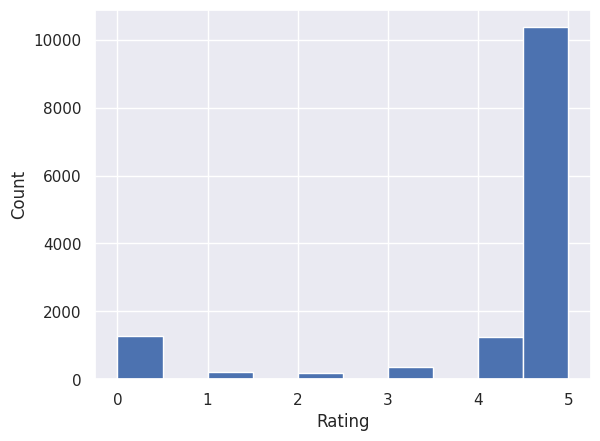

In [12]:
sns.set()
train_copy.Rating.hist()
plt.xlabel('Rating')
plt.ylabel('Count')

### % of each ratings in the train dataset

In [13]:
count_5 = train_copy[train_copy['Rating'] == 5]['Rating'].count()
count_4 = train_copy[train_copy['Rating'] == 4]['Rating'].count()
count_3 = train_copy[train_copy['Rating'] == 3]['Rating'].count()
count_2 = train_copy[train_copy['Rating'] == 2]['Rating'].count()
count_1 = train_copy[train_copy['Rating'] == 1]['Rating'].count()
count_0 = train_copy[train_copy['Rating'] == 0]['Rating'].count()
total = train_copy['Rating'].count()
print(f"Count of value 5: {count_5/total * 100}")
print(f"Count of value 4: {count_4/total * 100}")
print(f"Count of value 3: {count_3/total * 100}")
print(f"Count of value 2: {count_2/total * 100}")
print(f"Count of value 1: {count_1/total * 100}")
print(f"Count of value 0: {count_0/total * 100}")

Count of value 5: 76.05602816075096
Count of value 4: 9.10090935758287
Count of value 3: 2.698738633030214
Count of value 2: 1.2760340275740685
Count of value 1: 1.5400410677618068
Count of value 0: 9.328248753300088


Splitting features into numerical and categorical columns.

In [14]:
numericals_cols = train_copy.select_dtypes(include=['float64', 'int64'])
categorical_cols = train_copy.select_dtypes(include='object')

In [15]:
numericals_cols['Rating'].value_counts()

Rating
5    10371
0     1272
4     1241
3      368
1      210
2      174
Name: count, dtype: int64

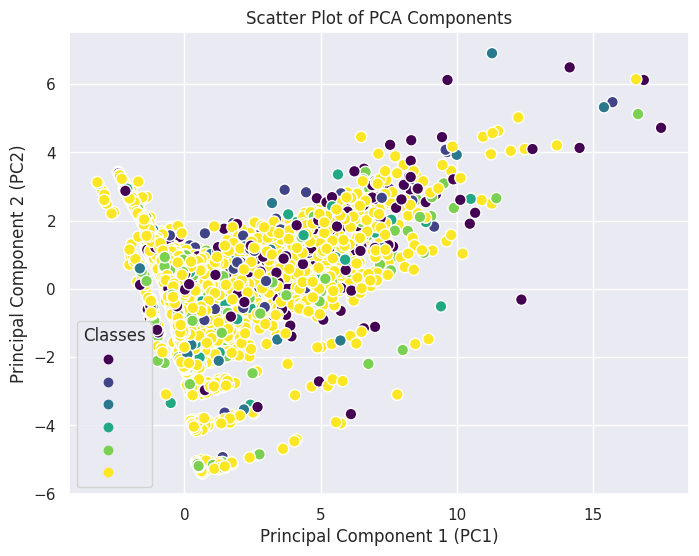

In [16]:
y = numericals_cols.Rating
X = numericals_cols.drop(columns=['Rating'], axis=1)

X_std = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df['Target'] = y

plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['PC1'], df['PC2'], c=df['Target'], cmap='viridis', edgecolors='w', s=70)
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('Scatter Plot of PCA Components')
plt.legend(handles=scatter.legend_elements()[0], title='Classes')
plt.show()

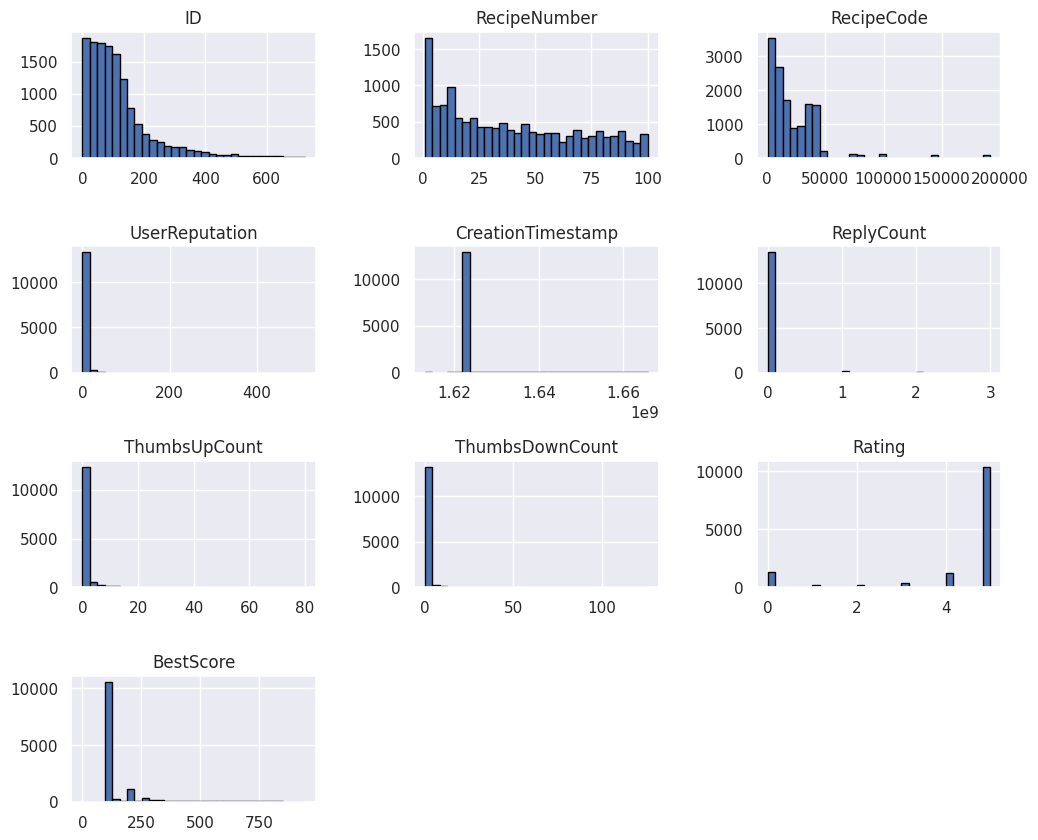

In [17]:
numericals_cols.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

### Pairplot to see correlation

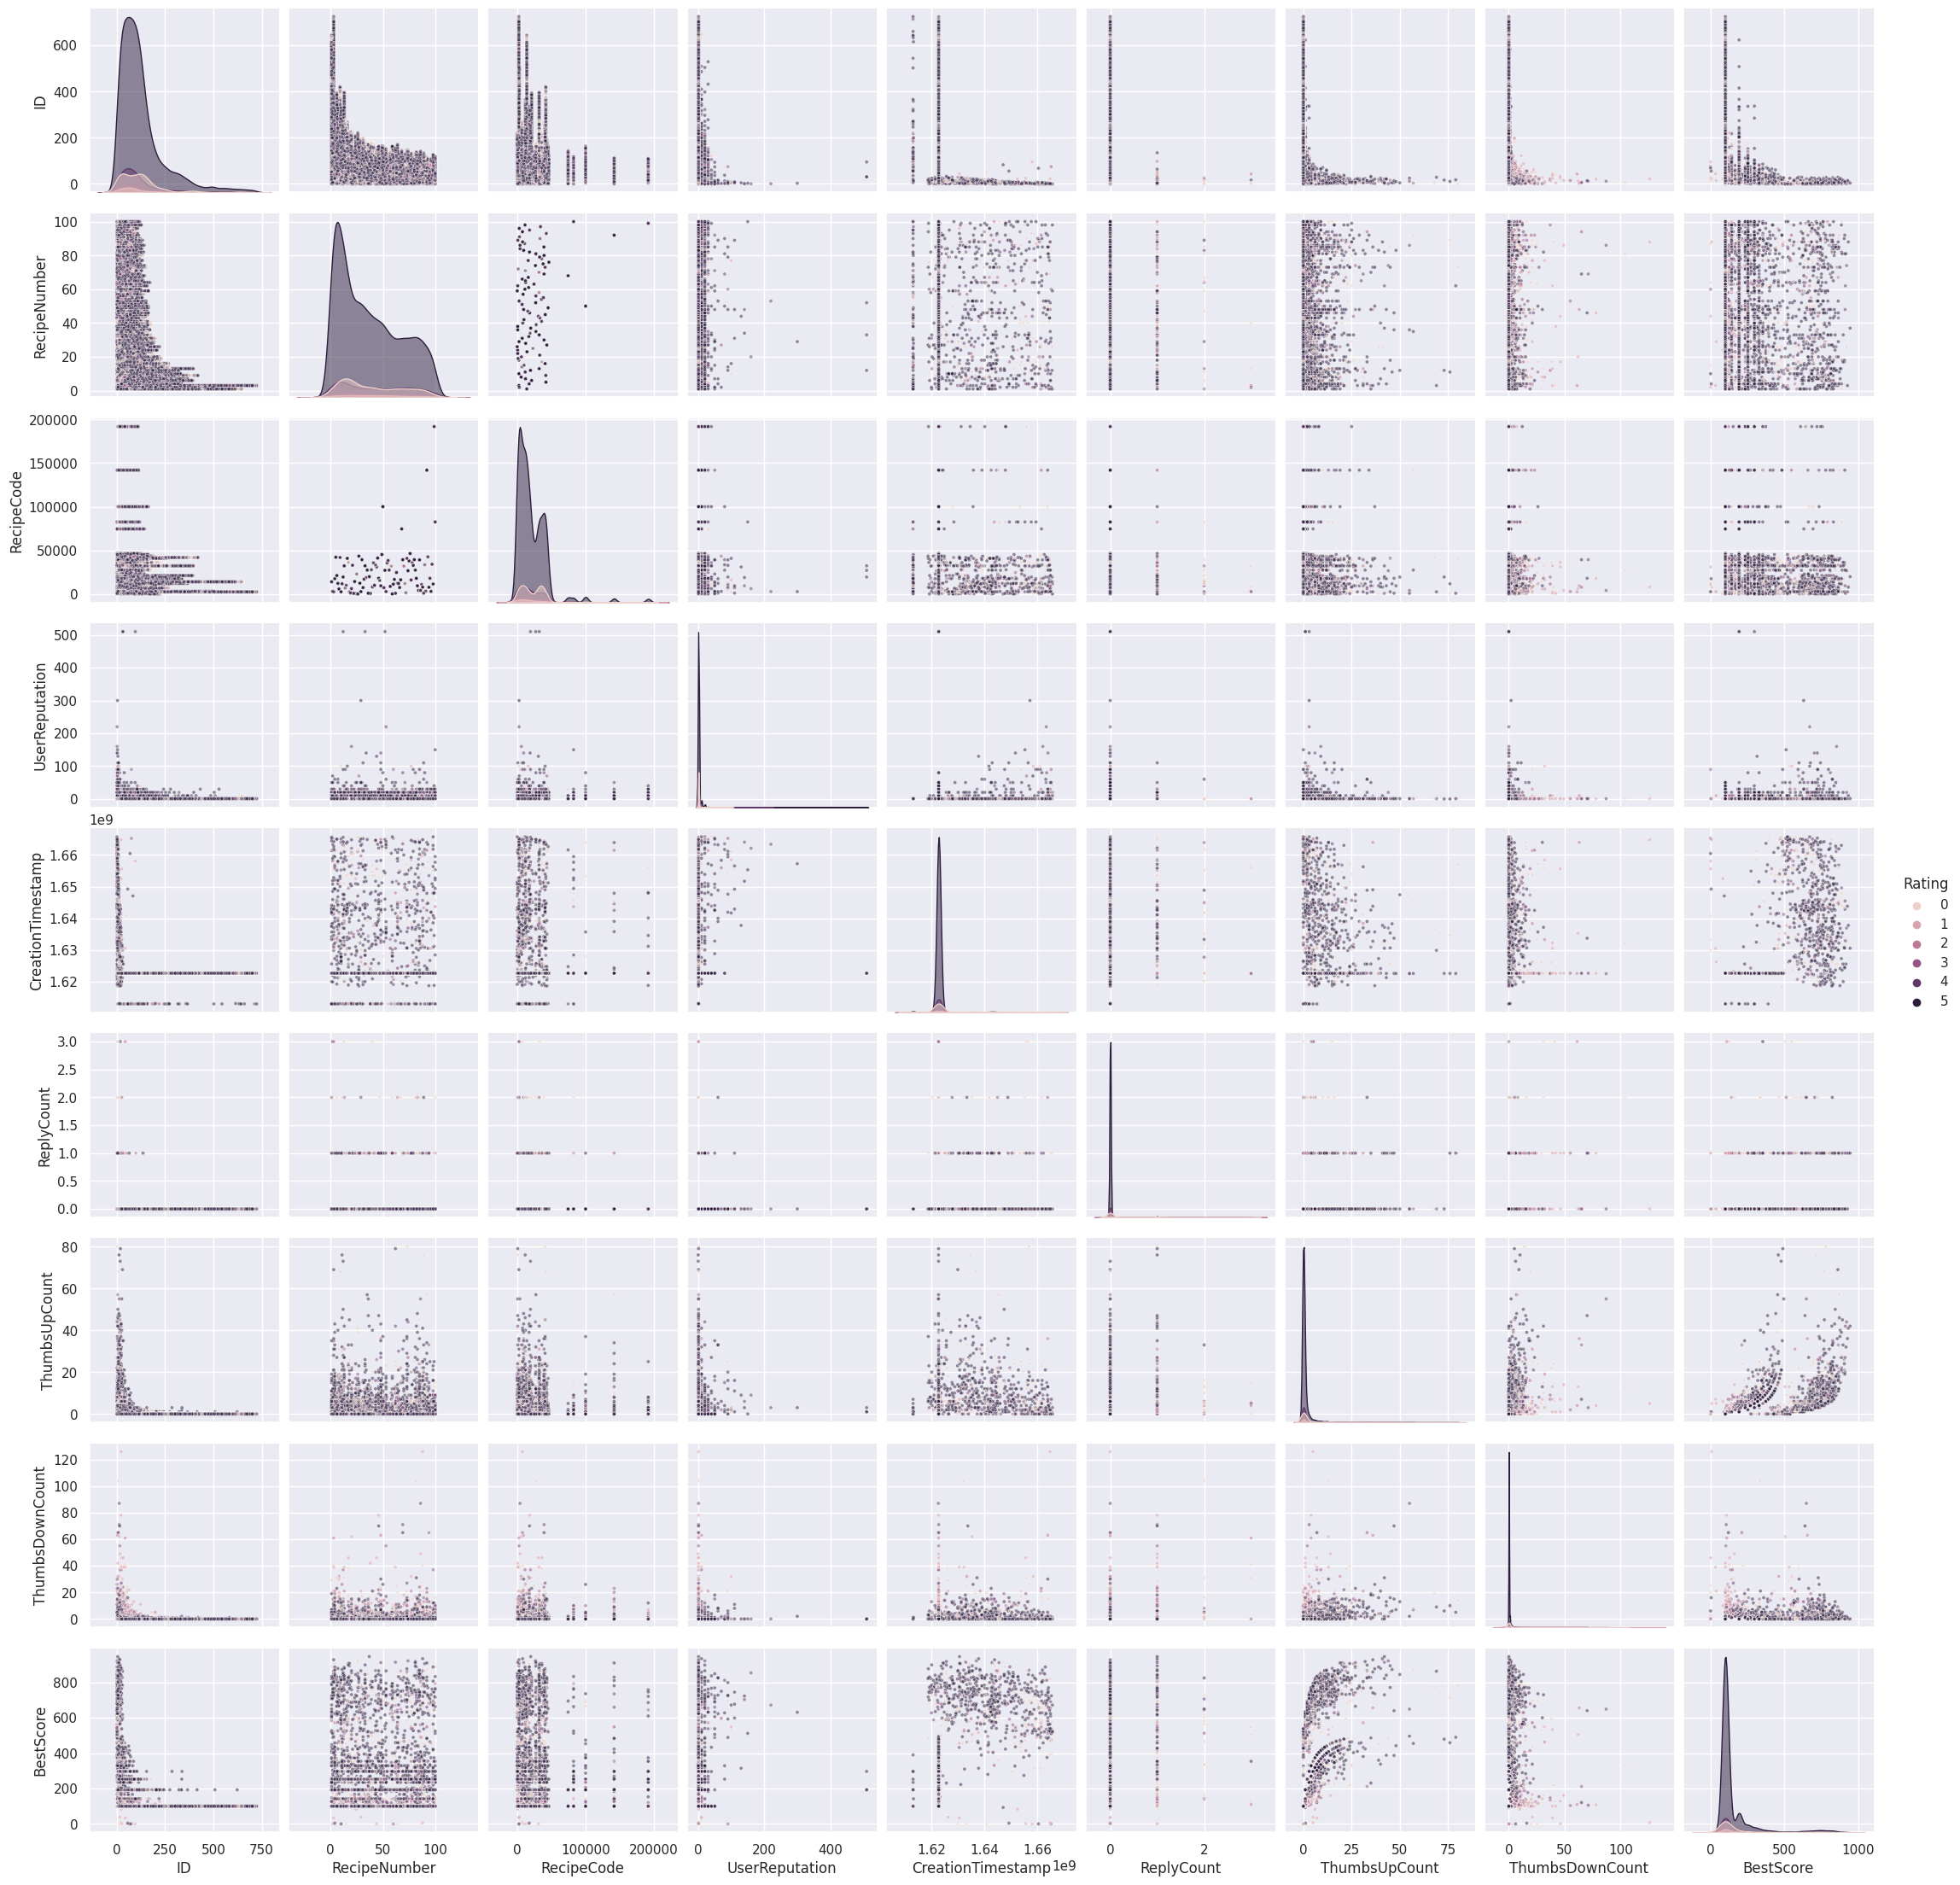

In [18]:
sns.pairplot(numericals_cols, hue='Rating', diag_kind='kde', kind='scatter', plot_kws={'alpha':0.5}, diag_kws={'alpha':0.5}, markers='.')

### Heatmap: To visualize correlation on heatmap

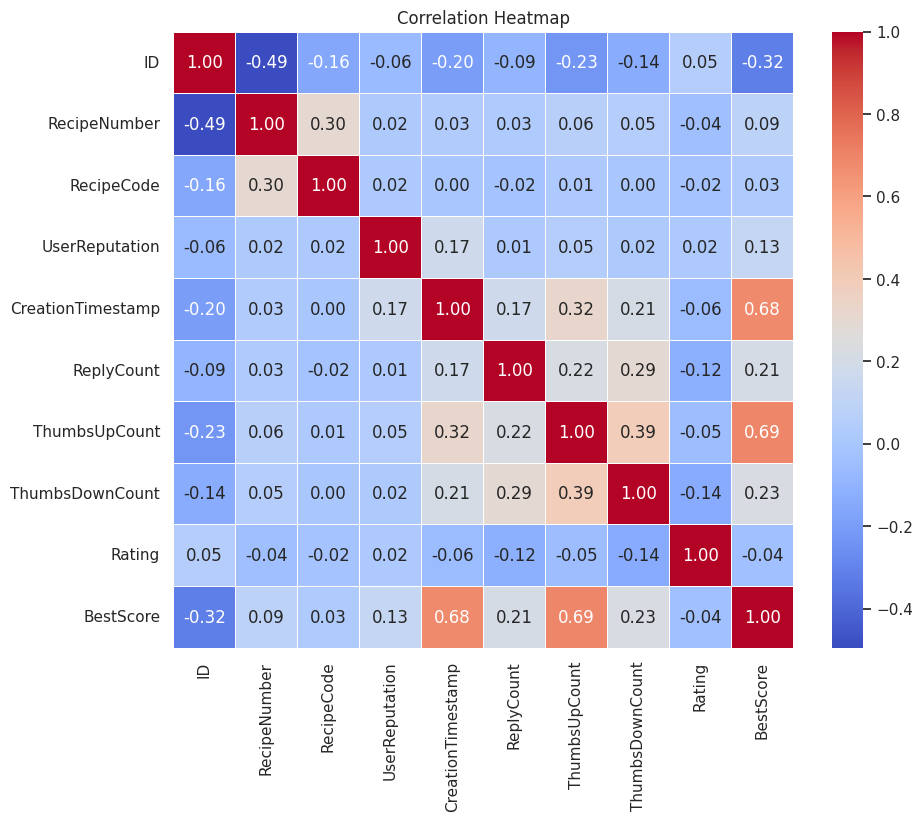

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(numericals_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

We can see the highest negative correlation of  `RecipeNumber` with `ID` and positive highest correlation of `BestScore` with `CreationTimestamp` and `ThumbsUpCount`.

### Box plot: Detecting Outliers

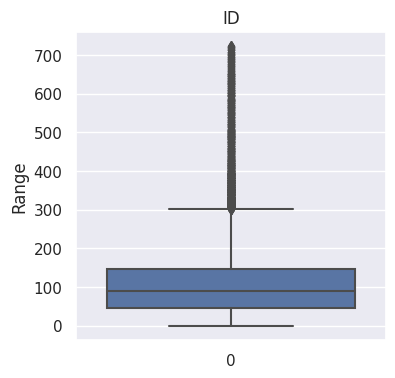

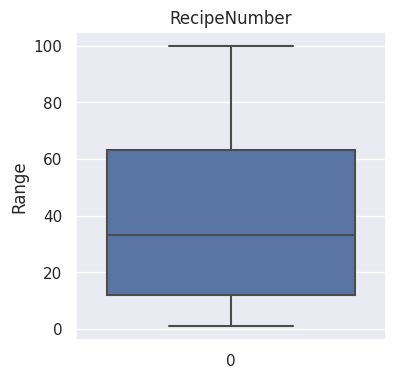

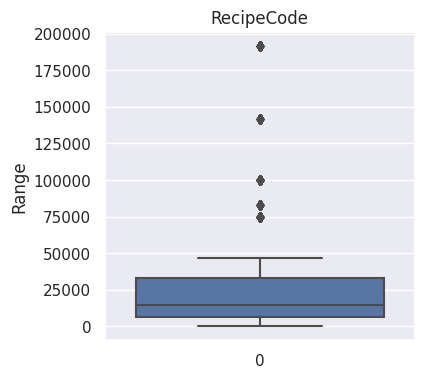

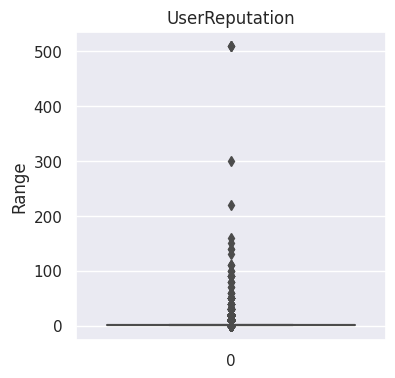

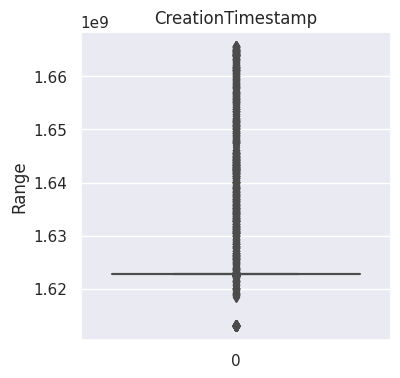

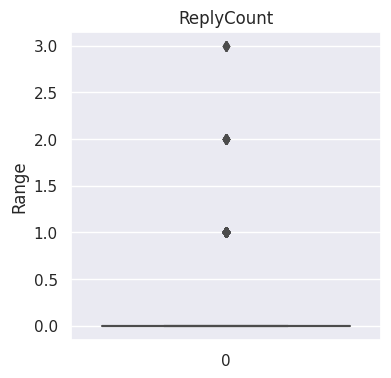

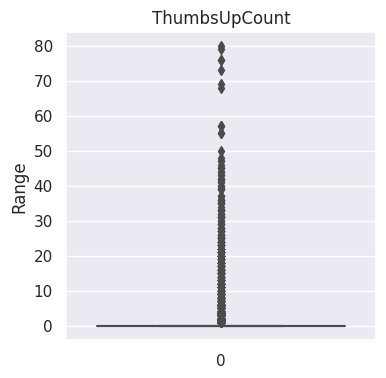

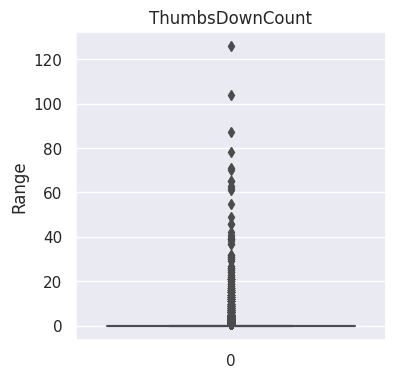

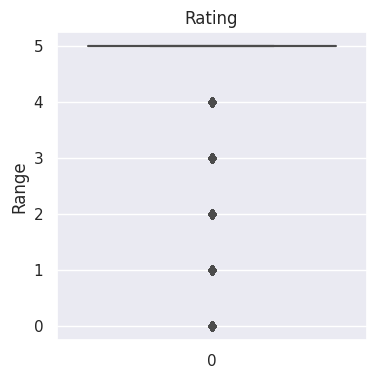

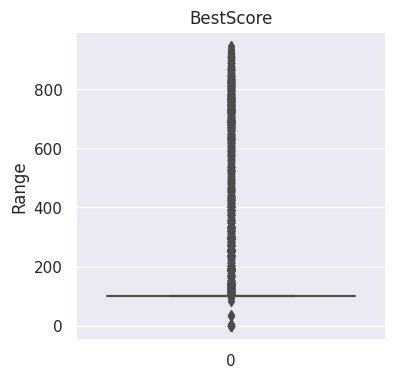

In [20]:
for feature in numericals_cols:
  plt.figure(figsize=(4,4))
  sns.boxplot(data=numericals_cols[feature])
  plt.title(feature)
  plt.ylabel('Range')
  plt.show()

# **Data Pre-processing Techniques**

In [21]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


In [22]:
test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4546 entries, 0 to 4545
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 4546 non-null   int64 
 1   RecipeNumber       4546 non-null   int64 
 2   RecipeCode         4546 non-null   int64 
 3   RecipeName         4546 non-null   object
 4   CommentID          4546 non-null   object
 5   UserID             4546 non-null   object
 6   UserName           4546 non-null   object
 7   UserReputation     4546 non-null   int64 
 8   CreationTimestamp  4546 non-null   int64 
 9   ReplyCount         4546 non-null   int64 
 10  ThumbsUpCount      4546 non-null   int64 
 11  ThumbsDownCount    4546 non-null   int64 
 12  BestScore          4546 non-null   int64 
 13  Recipe_Review      4546 non-null   object
dtypes: int64(9), object(5)
memory usage: 497.3+ KB


As we can see the `Recipe_Review` has two samples with null. Since the number of such samples are really low so we will ignore remove those.

In [23]:
train_copy.dropna(inplace=True)

In [24]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13634 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13634 non-null  int64 
 1   RecipeNumber       13634 non-null  int64 
 2   RecipeCode         13634 non-null  int64 
 3   RecipeName         13634 non-null  object
 4   CommentID          13634 non-null  object
 5   UserID             13634 non-null  object
 6   UserName           13634 non-null  object
 7   UserReputation     13634 non-null  int64 
 8   CreationTimestamp  13634 non-null  int64 
 9   ReplyCount         13634 non-null  int64 
 10  ThumbsUpCount      13634 non-null  int64 
 11  ThumbsDownCount    13634 non-null  int64 
 12  Rating             13634 non-null  int64 
 13  BestScore          13634 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.7+ MB


## Handling text and categorical attributes: Basically the Recipe_Review column

In [25]:
train_copy.dropna(inplace=True)

Removing numbers: This is to remove any digits or numbers that are not relevant for the analysis. For example, “There are 3 balls in this bag” can be simplified to “There are balls in this bag”.

In [26]:
train_copy['Recipe_Review'] = train_copy['Recipe_Review'].str.lower()
test_copy['Recipe_Review'] = test_copy['Recipe_Review'].str.lower()

In [27]:
train_copy['Recipe_Review'] = train_copy['Recipe_Review'].str.replace(r'\d+', '', regex=True)
test_copy['Recipe_Review'] = test_copy['Recipe_Review'].str.replace(r'\d+', '', regex=True)

Removing punctuation: This is to remove any symbols or marks that are not part of the words. For example, “Hey, did you know that the summer break is coming?” can be simplified to “Hey did you know that the summer break is coming”.

In [28]:
train_copy['Recipe_Review'] = train_copy['Recipe_Review'].str.replace('[{}]'.format(string.punctuation), '', regex=True)
test_copy['Recipe_Review'] = test_copy['Recipe_Review'].str.replace('[{}]'.format(string.punctuation), '', regex=True)

Removing Special Characters: Removing the special characters from the text feedbacks

In [29]:
train_copy['Recipe_Review'] = train_copy['Recipe_Review'].str.replace('[^a-zA-Z \s]', '', regex=True)# removing any special characters
test_copy['Recipe_Review'] = test_copy['Recipe_Review'].str.replace('[^a-zA-Z \s]', '', regex=True)# removing any special characters

## Feature Engineering

## Converting categories to numbers:

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_copy['Recipe_Review'])
X_test_data = vectorizer.transform(test_copy['Recipe_Review'])
vectorizer.get_feature_names_out()
print(X.shape)

(13634, 12588)


In [31]:
X_dense_df = pd.DataFrame(X.toarray())
X_dense_df.index = range(len(X_dense_df))
X_dense_test = pd.DataFrame(X_test_data.toarray())
X_dense_test.index = range(len(X_dense_test))

In [32]:
train_copy['feedback_score'] = X_dense_df.sum()
test_copy['feedback_score'] = X_dense_test.sum()

In [33]:
train_copy.dropna(inplace=True)

In [34]:
y = train_copy['Rating']
X = train_copy.drop(columns=['Rating', 'Recipe_Review', 'CommentID', 'UserID'], axis=1)

In [35]:
test_copy = test_copy.drop(columns=['Recipe_Review', 'CommentID', 'UserID'], axis=1)

In [36]:
numeric_features = ['ID', 'RecipeNumber', 'RecipeCode', 'feedback_score',  'UserReputation', 'CreationTimestamp', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'BestScore']
categorical_features = ['RecipeName', 'UserName']

In [37]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

In [38]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [39]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Train, Test, Dev splits

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [41]:
cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)

# **Select Model and Finetuning**

## Dummyclassifier for classification.

---



In [42]:
dummy_mlti_clf_pipeline = Pipeline(
                              steps=[("preprocessor", preprocessor),
                                    ("classifier", DummyClassifier(random_state = 1))]
                          )
dummy_mlti_clf_cv_results = cross_validate(dummy_mlti_clf_pipeline,
                                    X,
                                    y,
                                    cv=cv,
                                    scoring="accuracy",
                                    return_train_score=True,
                                     return_estimator=True)

dummy_mlti_clf_train_error = -1 * dummy_mlti_clf_cv_results['train_score']
dummy_mlti_clf_test_error = -1 * dummy_mlti_clf_cv_results['test_score']

print(f"Mean absolute error of Dummy Classification model on the train set:\n"
      f"{dummy_mlti_clf_train_error.mean():.3f} +/- {dummy_mlti_clf_train_error.std():.3f}")
print(f"Mean absolute error of Dummy Classification model on the test set:\n"
      f"{dummy_mlti_clf_test_error.mean():.3f} +/- {dummy_mlti_clf_test_error.std():.3f}")

Mean absolute error of Dummy Classification model on the train set:
-0.760 +/- 0.000
Mean absolute error of Dummy Classification model on the test set:
-0.759 +/- 0.000


In [43]:
best_model_index = np.argmax(dummy_mlti_clf_cv_results['test_score'])
best_dummy_model = dummy_mlti_clf_cv_results['estimator'][best_model_index]

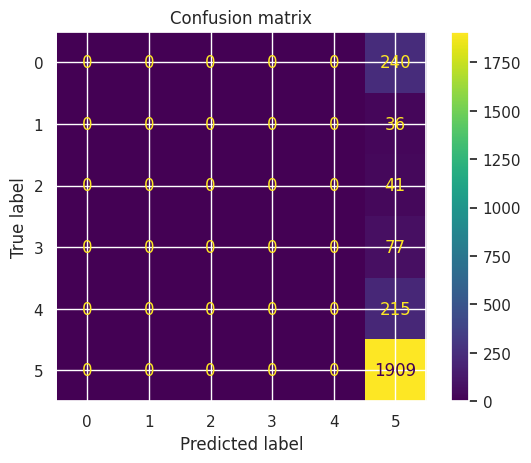

In [44]:
y_test_predicted = best_dummy_model.predict(X_test)
cm = confusion_matrix(y_test, y_test_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_dummy_model[-1].classes_)
disp.plot(include_values=True, cmap='viridis')  # Include values inside the cells and specify a color map
plt.title('Confusion matrix')
plt.show()


## RandomForestClassifier Model for classification.

---



In [45]:
rfg_mlti_clf_pipeline = Pipeline(
                              steps=[("preprocessor", preprocessor),
                                    ("classifier", RandomForestClassifier(random_state = 1))]
                          )
rfg_mlti_clf_cv_results = cross_validate(rfg_mlti_clf_pipeline,
                                    X,
                                    y,
                                    cv=cv,
                                    scoring="accuracy",
                                    return_train_score=True,
                                     return_estimator=True)

rfg_mlti_clf_train_error = rfg_mlti_clf_cv_results['train_score']
rfg_mlti_clf_test_error = rfg_mlti_clf_cv_results['test_score']

print(f"Mean absolute error of RandomForestClassifier Classification model on the train set:\n"
      f"{rfg_mlti_clf_train_error.mean():.3f} +/- {rfg_mlti_clf_train_error.std():.3f}")
print(f"Mean absolute error of RandomForestClassifier Classification model on the test set:\n"
      f"{rfg_mlti_clf_test_error.mean():.3f} +/- {rfg_mlti_clf_test_error.std():.3f}")
rfg_mlti_clf_pipeline.fit(X_train, y_train)
print("model score: %.3f" % rfg_mlti_clf_pipeline.score(X_test, y_test))

Mean absolute error of RandomForestClassifier Classification model on the train set:
1.000 +/- 0.000
Mean absolute error of RandomForestClassifier Classification model on the test set:
0.771 +/- 0.002
model score: 0.769


In [46]:
best_model_index = np.argmax(rfg_mlti_clf_cv_results['test_score'])
best_rfg_model = rfg_mlti_clf_cv_results['estimator'][best_model_index]

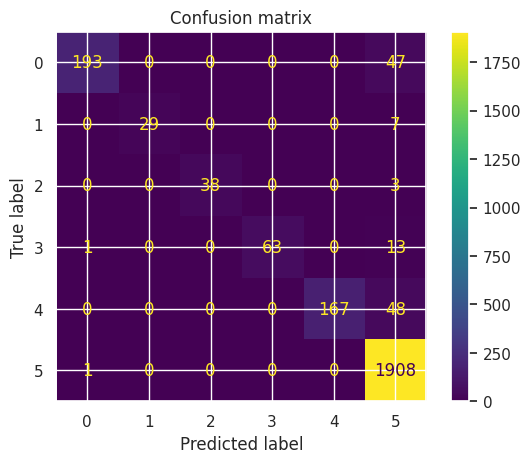

In [47]:
y_test_predicted = best_rfg_model.predict(X_test)
cm = confusion_matrix(y_test, y_test_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rfg_model[-1].classes_)
disp.plot(include_values=True, cmap='viridis')  # Include values inside the cells and specify a color map
plt.title('Confusion matrix')
plt.show()

In [48]:
class_report = classification_report(y_test, y_test_predicted)
print("Classification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.89       240
           1       1.00      0.81      0.89        36
           2       1.00      0.93      0.96        41
           3       1.00      0.82      0.90        77
           4       1.00      0.78      0.87       215
           5       0.94      1.00      0.97      1909

    accuracy                           0.95      2518
   macro avg       0.99      0.86      0.91      2518
weighted avg       0.95      0.95      0.95      2518



In [49]:
# Define the parameter grid
param_grid = {
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True, False]
}

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(rfg_mlti_clf_pipeline, param_distributions=param_grid, n_iter=100, cv=cv, scoring='accuracy', random_state=1)

# Fit the search object
random_search.fit(X, y)

# Extract and analyze the best hyperparameters
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters: {'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': None, 'classifier__bootstrap': False}
Best Score: 0.77263701350278


## XGBClassifier Model for classification.

---

In [50]:
xgboost_multi_clf_pipeline = Pipeline(
                              steps=[("preprocessor", preprocessor),
                                    ("classifier", XGBClassifier(objective='binary:logistic',
                          scale_pos_weight=np.sum(y == 0) / np.sum(y == 1),
                          # Adjust scale_pos_weight based on class imbalance
                          max_depth=5,  # Set other hyperparameters as needed
                          learning_rate=0.1,
                          n_estimators=100))]
                          )
xgboost_mlti_clf_cv_results = cross_validate(dummy_mlti_clf_pipeline,
                                    X,
                                    y,
                                    cv=cv,
                                    scoring="accuracy",
                                    return_train_score=True,
                                     return_estimator=True)

lin_reg_train_error = -1 * xgboost_mlti_clf_cv_results['train_score']
lin_reg_test_error = -1 * xgboost_mlti_clf_cv_results['test_score']

print(f"Mean absolute error of Dummy Classification model on the train set:\n"
      f"{lin_reg_train_error.mean():.3f} +/- {lin_reg_train_error.std():.3f}")
print(f"Mean absolute error of Dummy Classification model on the test set:\n"
      f"{lin_reg_test_error.mean():.3f} +/- {lin_reg_test_error.std():.3f}")

Mean absolute error of Dummy Classification model on the train set:
-0.760 +/- 0.000
Mean absolute error of Dummy Classification model on the test set:
-0.759 +/- 0.000


In [51]:
best_model_index = np.argmax(xgboost_mlti_clf_cv_results['test_score'])
best_xgboost_model = xgboost_mlti_clf_cv_results['estimator'][best_model_index]

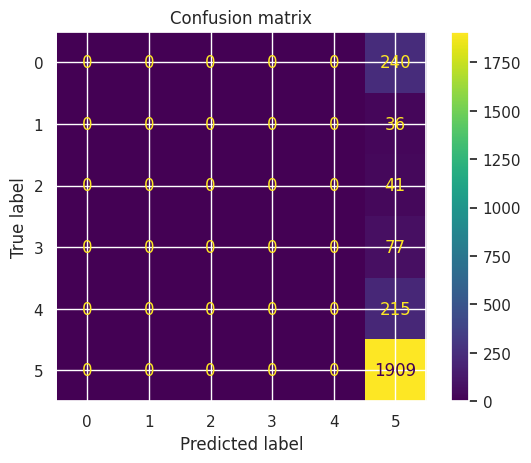

In [52]:
y_test_predicted = best_xgboost_model.predict(X_test)
cm = confusion_matrix(y_test, y_test_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgboost_model[-1].classes_)
disp.plot(include_values=True, cmap='viridis')  # Include values inside the cells and specify a color map
plt.title('Confusion matrix')
plt.show()

In [53]:
class_report = classification_report(y_test, y_test_predicted)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       240
           1       0.00      0.00      0.00        36
           2       0.00      0.00      0.00        41
           3       0.00      0.00      0.00        77
           4       0.00      0.00      0.00       215
           5       0.76      1.00      0.86      1909

    accuracy                           0.76      2518
   macro avg       0.13      0.17      0.14      2518
weighted avg       0.57      0.76      0.65      2518



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
param_grid = {
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.05],
    'classifier__n_estimators': [50, 100],
    'classifier__gamma': [0, 0.1],
    'classifier__min_child_weight': [1, 5],
    'classifier__subsample': [0.6, 0.8],
    'classifier__colsample_bytree': [0.6, 0.8]
}

# Create the XGBoost pipeline
xgboost_multi_clf_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", XGBClassifier(objective='binary:logistic'))]
)

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgboost_multi_clf_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='accuracy',
    random_state=1,
    verbose=1
)

# Fit the search object
random_search.fit(X, y)

# Extract and analyze the best hyperparameters
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters: {'classifier__subsample': 0.6, 'classifier__n_estimators': 100, 'classifier__min_child_weight': 1, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.8}
Best Score: 0.7676785310247742


## SVC Model for classification.

---

In [55]:
# Define the pipeline with Support Vector Classifier
svc_multi_clf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", SVC(kernel="linear", random_state=1, probability=True))
    ]
)

# Train the model with cross-validation
svc_multi_clf_cv_results = cross_validate(
    svc_multi_clf_pipeline,
    X,
    y,
    cv=cv,
    scoring="accuracy",
    return_train_score=True,
    return_estimator=True
)

# Calculate training and test errors
svc_train_error = -1 * svc_multi_clf_cv_results['train_score']
svc_test_error = -1 * svc_multi_clf_cv_results['test_score']

# Print the mean absolute error
print(f"Mean absolute error of Support Vector Classifier model on the train set:\n"
      f"{svc_train_error.mean():.3f} +/- {svc_train_error.std():.3f}")
print(f"Mean absolute error of Support Vector Classifier model on the test set:\n"
      f"{svc_test_error.mean():.3f} +/- {svc_test_error.std():.3f}")

Mean absolute error of Support Vector Classifier model on the train set:
-0.948 +/- 0.000
Mean absolute error of Support Vector Classifier model on the test set:
-0.758 +/- 0.003


In [56]:
best_model_index = np.argmax(svc_multi_clf_cv_results['test_score'])
best_svc_model = svc_multi_clf_cv_results['estimator'][best_model_index]

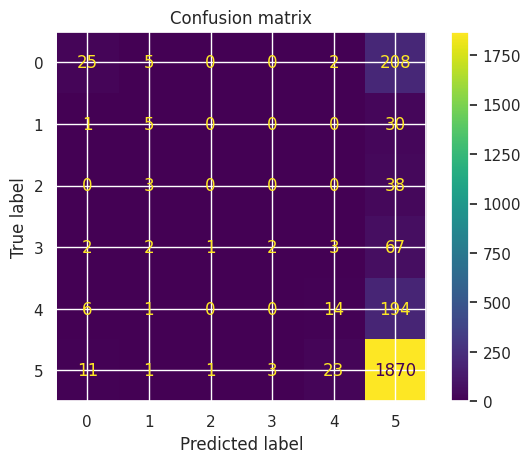

In [57]:
y_test_predicted = best_svc_model.predict(X_test)
cm = confusion_matrix(y_test, y_test_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svc_model[-1].classes_)
disp.plot(include_values=True, cmap='viridis')  # Include values inside the cells and specify a color map
plt.title('Confusion matrix')
plt.show()

In [58]:
class_report = classification_report(y_test, y_test_predicted)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.10      0.18       240
           1       0.29      0.14      0.19        36
           2       0.00      0.00      0.00        41
           3       0.40      0.03      0.05        77
           4       0.33      0.07      0.11       215
           5       0.78      0.98      0.87      1909

    accuracy                           0.76      2518
   macro avg       0.39      0.22      0.23      2518
weighted avg       0.69      0.76      0.69      2518



In [59]:
# Define the parameter grid for SVC
param_grid = {
    'classifier__C': [0.1, 1, 10],  # Regularization parameter
    'classifier__kernel': ['linear', 'rbf'],  # Type of kernel
    'classifier__gamma': ['scale', 'auto'],  # Kernel coefficient
}

# Create the pipeline with Support Vector Classifier
svc_multi_clf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", SVC(random_state=1))
    ]
)

# Instantiate GridSearchCV
grid_search = GridSearchCV(
    estimator=svc_multi_clf_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    verbose=1
)

# Fit the search object
grid_search.fit(X, y)

# Extract and analyze the best hyperparameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best Hyperparameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best Score: 0.7642970611596505


# **Performance on the test set**

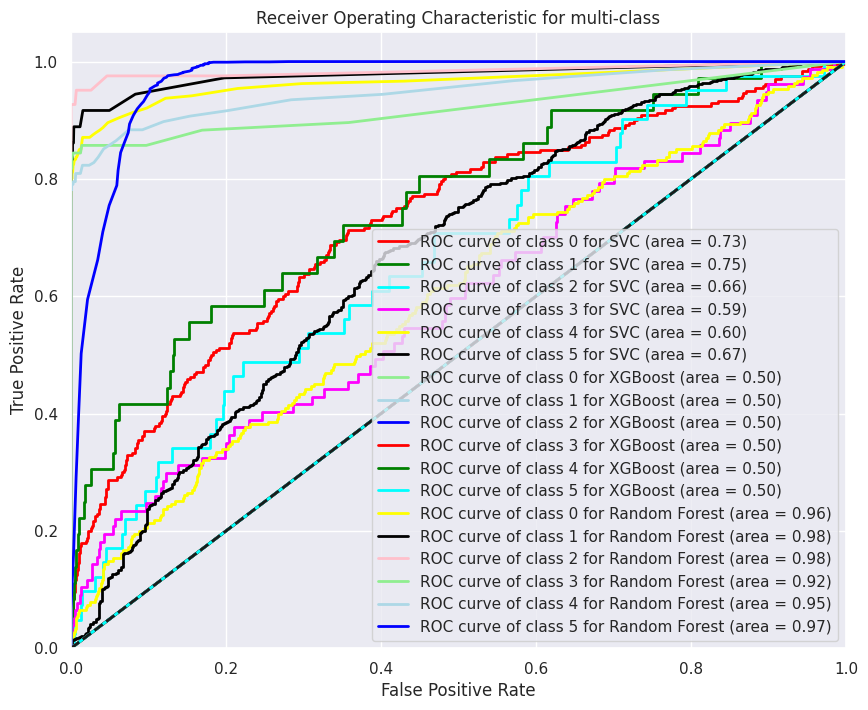

In [60]:
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Calculate the ROC curve and AUC for each model and each class
n_classes = y_test_binarized.shape[1]
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 'lightblue'])

# Plot linewidth
lw = 2

# Compute ROC curve and ROC area for each class
def compute_roc_auc(model, X_test, y_test_binarized):
    y_score = model.predict_proba(X_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

# Plot all ROC curves
plt.figure(figsize=(10, 8))

models = [
    ('SVC', best_svc_model),
    ('XGBoost', best_xgboost_model),
    ('Random Forest', best_rfg_model)
]

for (name, model), color in zip(models, colors):
    fpr, tpr, roc_auc = compute_roc_auc(model, X_test, y_test_binarized)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} for {1} (area = {2:0.2f})'
                 ''.format(i, name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

In [61]:
train_data = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv')
test_data = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv')
train_data.dropna(inplace=True)
train_data['Recipe_Review'] = train_data['Recipe_Review'].str.lower()
test_data['Recipe_Review'] = test_data['Recipe_Review'].str.lower()
train_data['Recipe_Review'] = train_data['Recipe_Review'].str.replace(r'\d+', '', regex=True)
test_data['Recipe_Review'] = test_data['Recipe_Review'].str.replace(r'\d+', '', regex=True)
import string
train_data['Recipe_Review'] = train_data['Recipe_Review'].str.replace('[{}]'.format(string.punctuation), '', regex=True)
test_data['Recipe_Review'] = test_data['Recipe_Review'].str.replace('[{}]'.format(string.punctuation), '', regex=True)
train_data['Recipe_Review'] = train_data['Recipe_Review'].str.replace('[^a-zA-Z \s]', '', regex=True)# removing any special characters
test_data['Recipe_Review'] = test_data['Recipe_Review'].str.replace('[^a-zA-Z \s]', '', regex=True)# removing any special characters
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_data['Recipe_Review'])
X_test_data = vectorizer.transform(test_data['Recipe_Review'])
vectorizer.get_feature_names_out()
X_dense_df = pd.DataFrame(X.toarray())
X_dense_df.index = range(len(X_dense_df))
X_dense_test = pd.DataFrame(X_test_data.toarray())
X_dense_test.index = range(len(X_dense_test))
train_data['feedback_score'] = X_dense_df.sum()
test_data['feedback_score'] = X_dense_test.sum()
train_data.dropna(inplace=True)
y = train_data['Rating']
X = train_data.drop(columns=['Rating', 'Recipe_Review', 'CommentID', 'UserID'], axis=1)
test_data = test_data.drop(columns=['Recipe_Review', 'CommentID', 'UserID'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0)

numeric_features = ['ID', 'RecipeNumber', 'RecipeCode', 'UserReputation', 'CreationTimestamp', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'BestScore', 'feedback_score']
categorical_features = ['RecipeName', 'UserName']
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
from sklearn.ensemble import RandomForestClassifier
clf = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", RandomForestClassifier(random_state = 1))]
)
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))
y_pred = clf.predict(test_data)
new_df = pd.DataFrame({
    'ID': range(1, len(y_pred) + 1),
    'Rating': y_pred
})
new_df.to_csv('submission.csv', index=False)

model score: 0.772
